# IMAGE SEGMENTATION

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
import os
import PIL


from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

%matplotlib inline

In [2]:
print("TensorFlow version: ",tf.__version__)

TensorFlow version:  2.7.0


Checking the available CPU and GPU devices

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
print(tf.config.list_physical_devices())

Num GPUs Available:  1
Num CPUs Available:  1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Initial Preparation

### Train data

Setting the path to train images and masks.

In [104]:
train_x_loc = "../data/train_images/"
train_y_loc = "../data/train_masks/"

Extract the names of the image files and sort and store them in a list. This will later be iterated over to read and store the image and mask data.

In [105]:
img_names = sorted([s[:-4] for s in os.listdir(train_x_loc)])

In order to prevent clogging up the RAM, we will create batches of images.

In [7]:
TRAIN_BATCH_SIZE = 100

In [8]:
img_names_batches = [img_names[i:i + TRAIN_BATCH_SIZE] for i in range(0, len(img_names), TRAIN_BATCH_SIZE)]
print("Train images were split into batches of size {}.".format(TRAIN_BATCH_SIZE))
print("Number of batches = ",len(img_names_batches))

Train images were split into batches of size 100.
Number of batches =  3


### Image Configs

In [6]:
INPUT_SIZE = 512
N_CHANNEL = 3
N_CLASSES = 27

## Model Creation

### UNet

In [14]:
def get_unet():
    inputs = Input((INPUT_SIZE, INPUT_SIZE, N_CHANNEL))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = (pool1) # Dropout(0.2)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = (pool2) #Dropout(0.2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = (pool3) 

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    drop4 = (pool4) # Dropout(0.2)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(drop4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    up6 = BatchNormalization()(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    up7 = BatchNormalization()(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    up8 = BatchNormalization()(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    up9 = BatchNormalization()(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(N_CLASSES, (1, 1),activation="sigmoid")(conv9)

    model = tf.keras.Model(inputs=[inputs], outputs=[conv10])

    return model

In semantic segmentation, you need as many masks as you have object classes. 
In our dataset, each pixel in every mask has been assigned a single integer probability that it belongs to a 
certain class - 0 to 26. The correct class is the one with the highest probability. 

Sparse categorical crossentropy is more efficient than other loss functions when you're dealing with 
lots of classes and to perform pixel-wise multiclass prediction. 

## Training the model

### Creating CallBacks

A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).

In [12]:
# TensorBoard visuluaziations... this stuff is so freaking cool
# To visualize, execute the following commands in a new jupyter notebook:
# %load_ext tensorboard
# %tensorboard --logdir /tmp/tboard_logs8
tensorboard = TensorBoard(log_dir='/tmp/tboard_logs8', histogram_freq=0, write_graph=True, write_images=True)

class MyCustomCallback(tf.keras.callbacks.Callback):

  def on_train_batch_begin(self, batch, logs=None):
    print('\nTraining: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

  def on_train_batch_end(self, batch, logs=None):
    print('\nTraining: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))

  def on_test_batch_begin(self, batch, logs=None):
    print('\nEvaluating: batch {} begins at {}'.format(batch, datetime.datetime.now().time()))

  def on_test_batch_end(self, batch, logs=None):
    print('\nEvaluating: batch {} ends at {}'.format(batch, datetime.datetime.now().time()))

### Training

In [16]:
# Training configs
EPOCHS = 2
LEARNING_RATE = 0.001
CURRENT_SAVE_LOC = "saved_models/training_9/"

model = None

for img_names in img_names_batches:
    # Setting the model
    if model is None:
        print("No model set. Creating new model.")
        model = get_unet()
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])
        INITIAL_TRAIN = False
        print("UNet model created")
    else:
        model = tf.keras.models.load_model(CURRENT_SAVE_LOC)
        print("UNet model loaded")
        
    if model is None:
            print("!!! MODEL NOT SET !!!")
            break
              
    # Preparing the data
    x = []
    y = []
    print("Reading train data")
    for i in img_names:
        x.append(np.array(PIL.Image.open(train_x_loc + i + ".jpg").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))/255)
        y.append(to_categorical(np.array(PIL.Image.open(train_y_loc + i + ".png").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST)), N_CLASSES))
    x = np.array(x)
    y = np.array(y)
    # Reserve 10 samples for validation
    x_train = x[:-10]
    y_train = y[:-10]
    x_val = x[-10:]
    y_val = y[-10:]
    del x,y
    print("Train and Validation data created")
    

    # Training the model
    model.fit(x_train, y_train, batch_size=20, epochs=EPOCHS, validation_data=(x_val, y_val), shuffle=True, callbacks=[MyCustomCallback(),tensorboard])
    del x_train,y_train,x_val,y_val
    
    # Saving the model in two formats
    print("Saving the model")
    model.save(CURRENT_SAVE_LOC)
    model.save(CURRENT_SAVE_LOC + "my_model.h5")
    print("Saving the model at", CURRENT_SAVE_LOC)
    

No model set. Creating new model.
UNet model created
Reading train data
Train and Validation data created
Epoch 1/2

Training: batch 0 begins at 01:43:45.639725


2022-01-06 01:43:46.058135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Training: batch 0 ends at 01:44:03.500511
1/5 [=====>........................] - ETA: 1:11 - loss: 4.1328 - accuracy: 0.0090
Training: batch 1 begins at 01:44:03.570594

Training: batch 1 ends at 01:44:11.119828
2/5 [===========>..................] - ETA: 22s - loss: 3.7131 - accuracy: 0.1811 
Training: batch 2 begins at 01:44:11.153304

Training: batch 2 ends at 01:44:18.314110
3/5 [=================>............] - ETA: 14s - loss: 3.5725 - accuracy: 0.2267
Training: batch 3 begins at 01:44:18.330946

Training: batch 3 ends at 01:44:25.667483
4/5 [=======================>......] - ETA: 7s - loss: 3.5016 - accuracy: 0.2548 
Training: batch 4 begins at 01:44:25.691052

Training: batch 4 ends at 01:44:29.224781
5/5 [==============================] - ETA: 0s - loss: 3.4776 - accuracy: 0.2690
Evaluating: batch 0 begins at 01:44:29.487178


2022-01-06 01:44:29.579630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Evaluating: batch 0 ends at 01:44:30.810372
5/5 [==============================] - 45s 7s/step - loss: 3.4776 - accuracy: 0.2690 - val_loss: 3.2838 - val_accuracy: 0.3532
Epoch 2/2

Training: batch 0 begins at 01:44:30.820102

Training: batch 0 ends at 01:44:38.222944
1/5 [=====>........................] - ETA: 29s - loss: 3.2837 - accuracy: 0.3333
Training: batch 1 begins at 01:44:38.241425

Training: batch 1 ends at 01:44:45.866753
2/5 [===========>..................] - ETA: 22s - loss: 3.2827 - accuracy: 0.3245
Training: batch 2 begins at 01:44:45.894905

Training: batch 2 ends at 01:44:53.700071
3/5 [=================>............] - ETA: 15s - loss: 3.2815 - accuracy: 0.3346
Training: batch 3 begins at 01:44:53.728550

Training: batch 3 ends at 01:45:01.182234
4/5 [=======================>......] - ETA: 7s - loss: 3.2805 - accuracy: 0.3309 
Training: batch 4 begins at 01:45:01.192089

Training: batch 4 ends at 01:45:05.694050
5/5 [==============================] - ETA: 0s - loss:

2022-01-06 01:45:30.617407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Training: batch 0 ends at 01:45:40.381142
1/5 [=====>........................] - ETA: 42s - loss: 3.2802 - accuracy: 0.1744
Training: batch 1 begins at 01:45:40.483645

Training: batch 1 ends at 01:45:48.186863
2/5 [===========>..................] - ETA: 23s - loss: 3.2787 - accuracy: 0.1578
Training: batch 2 begins at 01:45:48.215624

Training: batch 2 ends at 01:45:55.632251
3/5 [=================>............] - ETA: 15s - loss: 3.2781 - accuracy: 0.1442
Training: batch 3 begins at 01:45:55.663627

Training: batch 3 ends at 01:46:03.123001
4/5 [=======================>......] - ETA: 7s - loss: 3.2766 - accuracy: 0.1462 
Training: batch 4 begins at 01:46:03.149854

Training: batch 4 ends at 01:46:06.677929
5/5 [==============================] - ETA: 0s - loss: 3.2758 - accuracy: 0.1442
Evaluating: batch 0 begins at 01:46:06.996124


2022-01-06 01:46:07.110921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Evaluating: batch 0 ends at 01:46:08.333753
5/5 [==============================] - 39s 7s/step - loss: 3.2758 - accuracy: 0.1442 - val_loss: 3.2656 - val_accuracy: 0.2278
Epoch 2/2

Training: batch 0 begins at 01:46:08.345655

Training: batch 0 ends at 01:46:15.735604
1/5 [=====>........................] - ETA: 29s - loss: 3.2672 - accuracy: 0.1263
Training: batch 1 begins at 01:46:15.765804

Training: batch 1 ends at 01:46:23.349924
2/5 [===========>..................] - ETA: 22s - loss: 3.2667 - accuracy: 0.1265
Training: batch 2 begins at 01:46:23.379200


KeyboardInterrupt: 

## Prediction

### Test data

Setting the path to test images. `test_y_loc` is the location where the predicted outputs should be saved.

In [22]:
test_x_loc = "../data/test_images/"
test_y_loc = "../data/test_preds/"

Extract the names of the test images and sort them and store them in a list.

In [23]:
test_img_names = sorted([s[:-4] for s in os.listdir(test_x_loc)])

In [10]:
print("Number of test images = ", len(test_img_names))

Number of test images =  1


### Ready the model

If `USE_CURRENT_MODEL` is False, then provide the location of the saved model you want to use in `SAVED_MODEL_LOC`.

In [11]:
USE_CURRENT_MODEL = False
SAVED_MODEL_LOC = "saved_models/training_9/"

In [12]:
if not USE_CURRENT_MODEL:
    model = tf.keras.models.load_model(SAVED_MODEL_LOC)
    print("Model loaded from ", SAVED_MODEL_LOC)

2022-01-06 15:45:40.237870: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-06 15:45:40.238019: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model loaded from  saved_models/training_9/


### Predict the output and save the mask as .png file

In [73]:
def get_predictions(test_img_names):
    y_test = {}
    print("Predicting for {} images".format(len(test_img_names)))
    for i in test_img_names:
        print("Predicting for img",i)
        x_test = np.array(PIL.Image.open(test_x_loc + i + ".jpg").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))/255
        x_test = x_test.reshape((1,512,512,3))
        y_test[i] = model.predict(x_test, verbose=1)
        del x_test
    return y_test

def create_mask(image_dict):
    y_test_mask = {}
    print("Creating masks for {} predictions".format(len(image_dict)))
    for name, img in image_dict.items():
        pred_mask = tf.argmax(img, axis=3)
        pred_mask= np.uint8(pred_mask[0].numpy())
        y_test_mask[name] = pred_mask
    return y_test_mask
        
def save_mask(mask_dict):
    for name, mask in mask_dict.items():
        im = PIL.Image.fromarray(mask)
        im.save(test_y_loc + name + '.png')
        print("Image saved: ", test_y_loc + name + '.png')

preds = get_predictions(test_img_names)
masks = create_mask(preds)
save_mask(masks)



Predicting for 2 images
Predicting for img 10170
1/1 [==============================] - 0s 12ms/step
Predicting for img 10171
1/1 [==============================] - 0s 13ms/step
Creating masks for 2 predictions
Image saved:  ../data/test_preds/10170.png
Image saved:  ../data/test_preds/10171.png


### Saving the output for kaggle submission

In [10]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)


def create_rles(test_pred_dir):
    """Used for Kaggle submission: predicts and encode all test images"""
    N = len([i for i in list(os.listdir(test_pred_dir)) if i[-3:] == "png"])
    with open('submission_file.csv', 'w') as f:
        f.write('ImageClassId,rle_mask\n')
        for index, i in enumerate(os.listdir(test_pred_dir)):
            if i[-3:] == "png":
                print('Saving {}/{}'.format(index, N))
                mask = PIL.Image.open(test_pred_dir + i)
                mask = mask.resize((1024, 1024))
                mask = np.array(mask)

                for x in range(1, 25):
                    enc = rle_encode(mask == x)
                    f.write(f"{i[:-4].split('_')[0]}_{x},{enc}\n")

create_rles(test_y_loc) 

###  >>>>> IGNORE THIS SECTION <<<<<<

In [103]:
# tf.keras.utils.plot_model(model)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


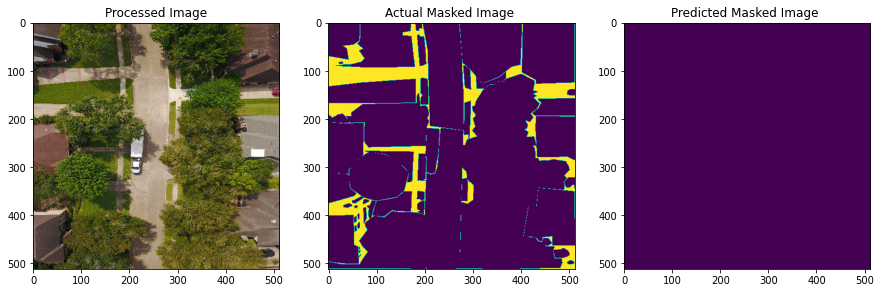

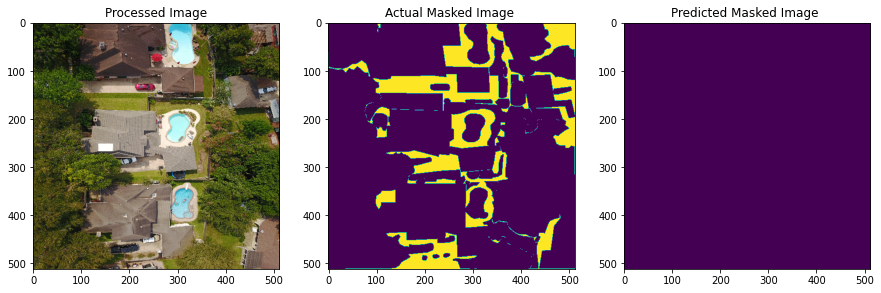

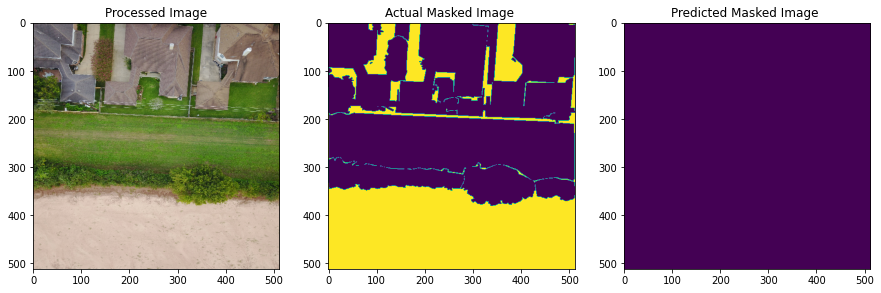

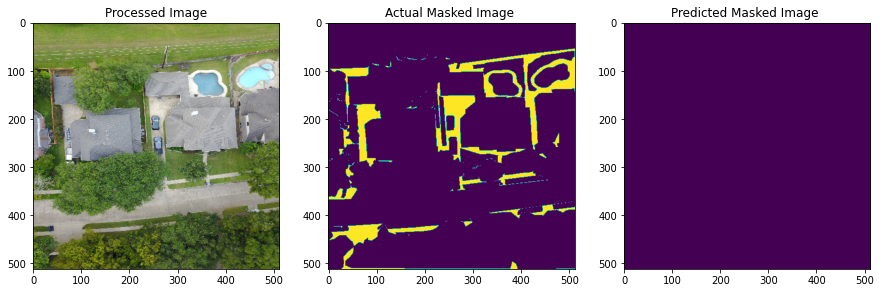

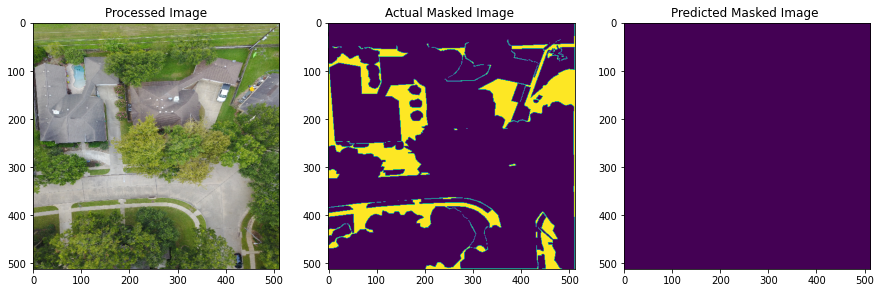

In [ ]:
# def VisualizeResults():
#     for i, m in dataset.take(5):
#       img = i
#       img = img[np.newaxis, ...]
#       pred_y = unet.predict(img)
# #       print(type(pred_y))
#       # create_rles(pred_y)
#       pred_mask = tf.argmax(pred_y[0], axis=-1)
#       pred_mask = pred_mask[..., tf.newaxis]
#       fig, arr = plt.subplots(1, 3, figsize=(15, 15))

#       arr[0].imshow(i)
#       arr[0].set_title('Processed Image')
#       arr[1].imshow(m[:,:,0])
#       arr[1].set_title('Actual Masked Image ')
#       arr[2].imshow(pred_mask[:,:,0])
#       arr[2].set_title('Predicted Masked Image ')

# VisualizeResults()

In [135]:
img_names = ['10172']

In [136]:
x = []
y = []
y_noncat = []
print("Reading train data")
for i in img_names:
    x.append(np.array(PIL.Image.open(train_x_loc + i + ".jpg").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST))/255)
    y_noncat.append(np.array(PIL.Image.open(train_y_loc + i + ".png").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST)))
    y.append(to_categorical(np.array(PIL.Image.open(train_y_loc + i + ".png").resize((INPUT_SIZE,INPUT_SIZE),resample=PIL.Image.NEAREST)), N_CLASSES))
    

Reading train data


In [145]:
print(len(y_noncat))
print(y_noncat)
print("********")
print(len(y))
print(y)

1
[array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 1, 0],
       [0, 1, 1, ..., 1, 1, 0],
       ...,
       [6, 6, 6, ..., 0, 0, 0],
       [6, 6, 6, ..., 0, 0, 0],
       [6, 0, 0, ..., 0, 0, 0]], dtype=uint8)]
********
1
[array([[[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

      

In [144]:
print(y_noncat[0].shape)
print(y_noncat[0])
print("********")
print(y[0].shape)
print(y[0])

(512, 512)
[[0 0 0 ... 0 0 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [6 6 6 ... 0 0 0]
 [6 6 6 ... 0 0 0]
 [6 0 0 ... 0 0 0]]
********
(512, 512, 27)
[[[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  ...
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  ...
  [0. 1. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 

In [146]:
print(y_noncat[0][0].shape)
print(y_noncat[0][0])
print("********")
print(y[0][0].shape)
print(y[0][0])

(512,)
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  5  5  5  5  5  5  5  5  5  5  5
  5  5  0  0 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [159]:
print(y_noncat[0][0].shape)
print(y_noncat[0][0])
print("********")
print(y[0][0][0].shape)
print(y[0][0][215])

(512,)
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  5  5  5  5  5  5  5  5  5  5  5
  5  5  0  0 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [119]:
print(y[0][0][0])

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


In [155]:
a = [0, 1, 2, 3]
b = tf.keras.utils.to_categorical(a, num_classes=4)
c = tf.constant(b, shape=[4, 4])
print(a)
print(b)
print(c)

[0, 1, 2, 3]
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
tf.Tensor(
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]], shape=(4, 4), dtype=float32)
